Siden dette datasettet i utgangspunktet har mange likheter med red wine datasette og jeg har analysert red-wine først kommer jeg til å bruke noen av analysene og kommentarene fra red-wine hvor det ikke er betydelige forskjellmellom datasettene.  

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from imblearn.over_sampling import SMOTENC
import seaborn as sb

In [98]:
df = pd.read_csv("../Oblig2/winequality-white.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Hensikten med datasettet er å muliggjøre analyse og modellering av vin kvalitet ut ifra forskjellige målte kjemiske karaterestikker (features) som for eks. «fixed acidity», «citric acid», "alcohol" osv.
Datasettet inneholder en target kolonne, «quality». Kolonnen oppgir en vurdering av kvaliteten til en vin og skal være oppgitt med en int-verdi fra 1-10 [1].
Videre inneholder datasettet 11 kolonner med feature verdier som beskrive forskjellige målte kjemiske egenskaper den enkelte vinen har. Alle disse kolonnen har en verditype av float.

ref [1]: UCI Irvine. (u.å). Wine Quality. Hentet 12.10.2025 fra "https://archive.ics.uci.edu/dataset/186/wine+quality"

In [99]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [100]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Ut i fra seksjonene over så ser det ikke ut til at det er noen manglende verdier i datasettet.

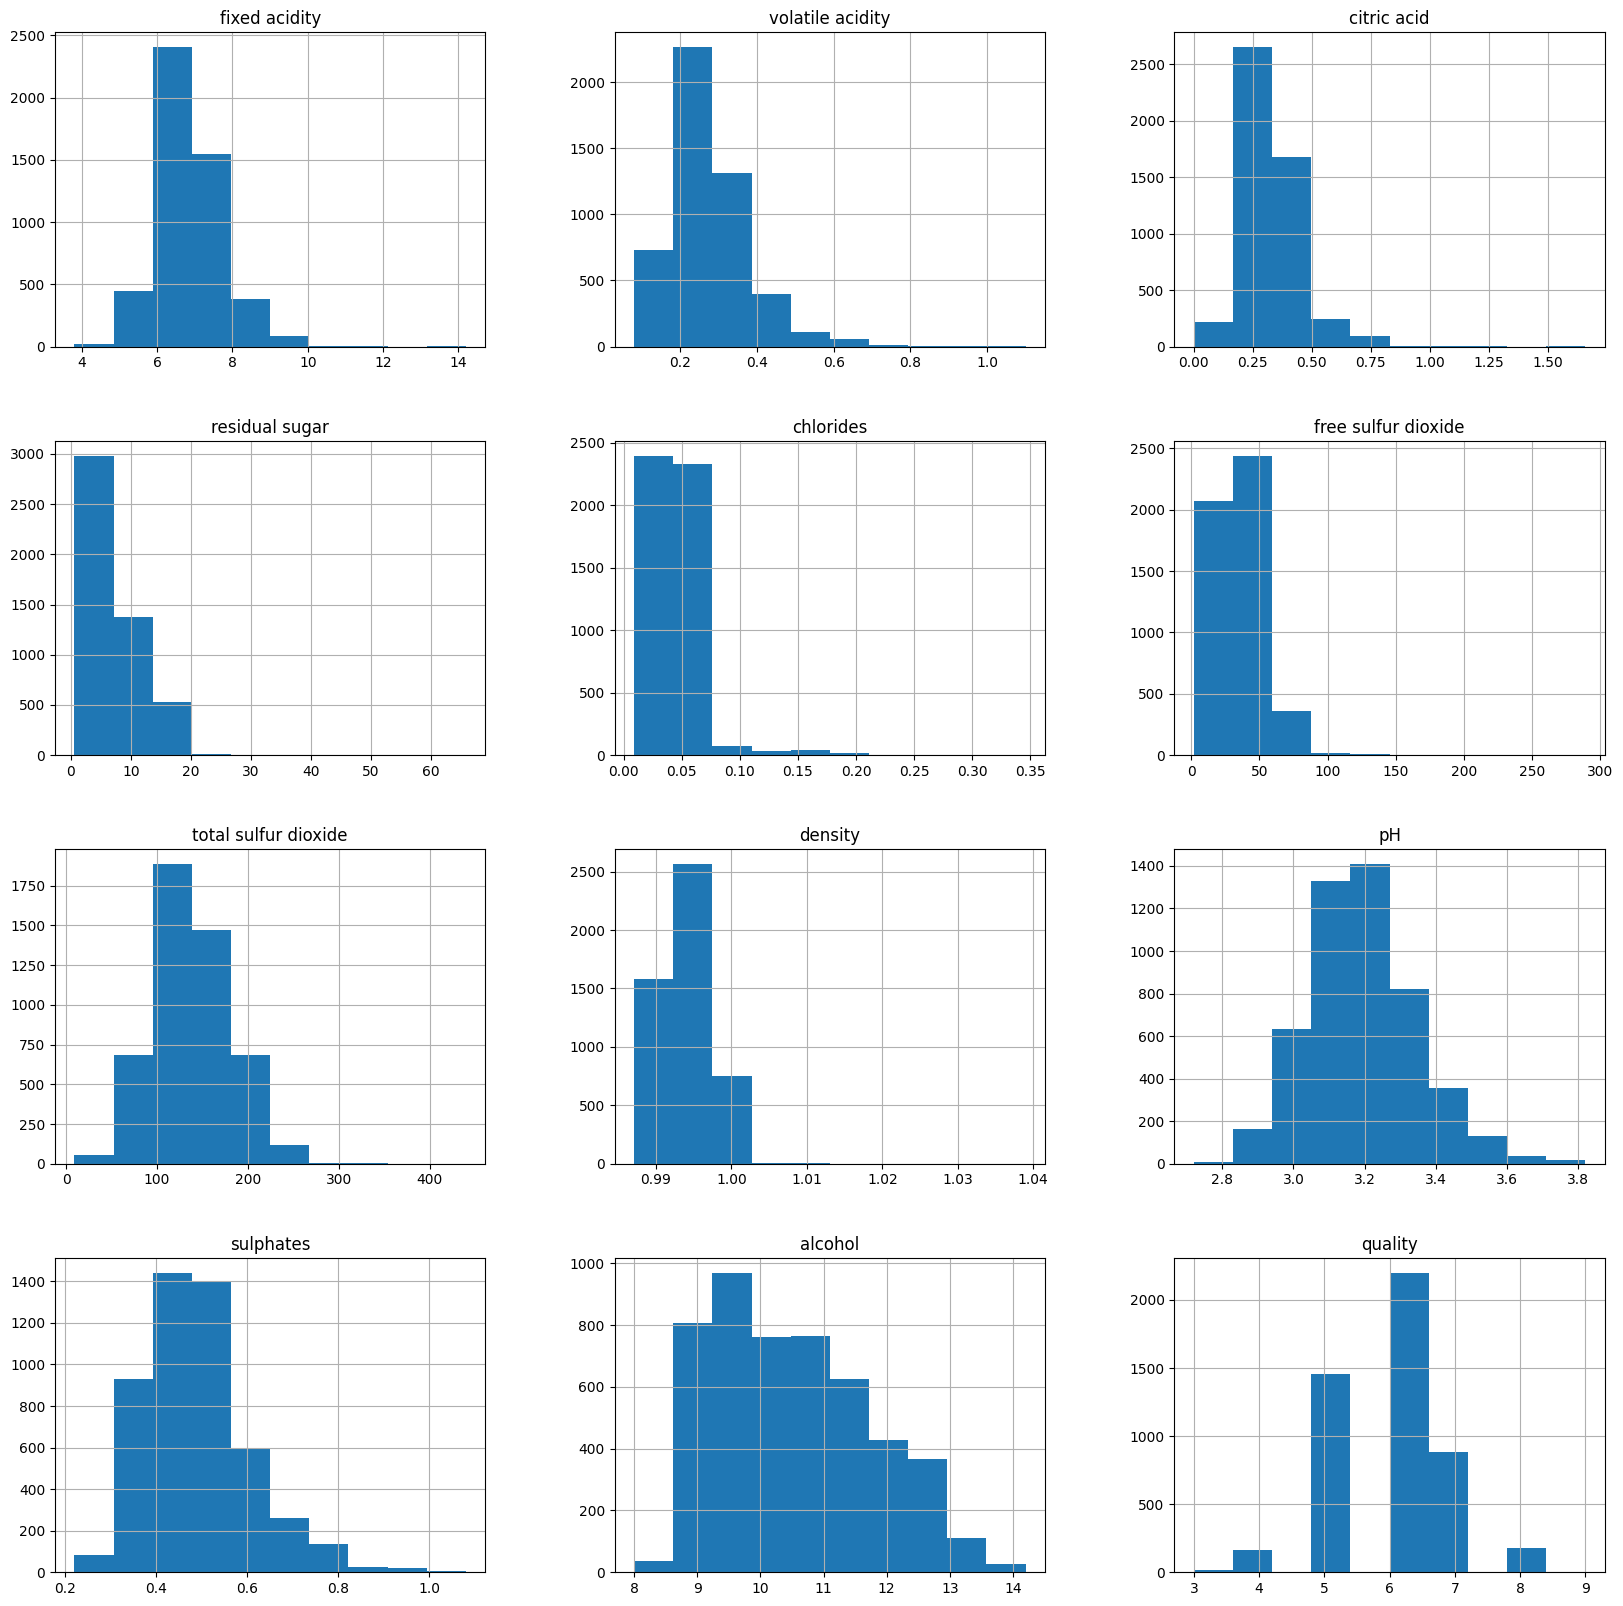

In [101]:
df.hist(figsize=(20,20))
plt.show()

Som vi ser ut i fra histogrammene i seksjonen over så ser datasettet i hovedsak ser ut til å være relativt normalfordelt eller ensidig normalfordelt. Det er imidlertid en betydelig forskjell i scaleringen til verdiene til de forskjellige featurene og det er dermed sansynelig at vi bør gjøre en vurdering i forhold scalering ved analysen av datasettet. 

I seksjonene under har jeg gjennomført en test scalering med MinMaxScaler, som vi ser ut i fra histogrammet etter denne scaleringen så x-verdiene nå fordelt i samme range mellom 0-1.

I den videre koden kommer jeg til å legge inn alternativ for scalering med både MinMaxScaler og StandardScaler, slik at begge disse kan testes ut ved trening av modelen.

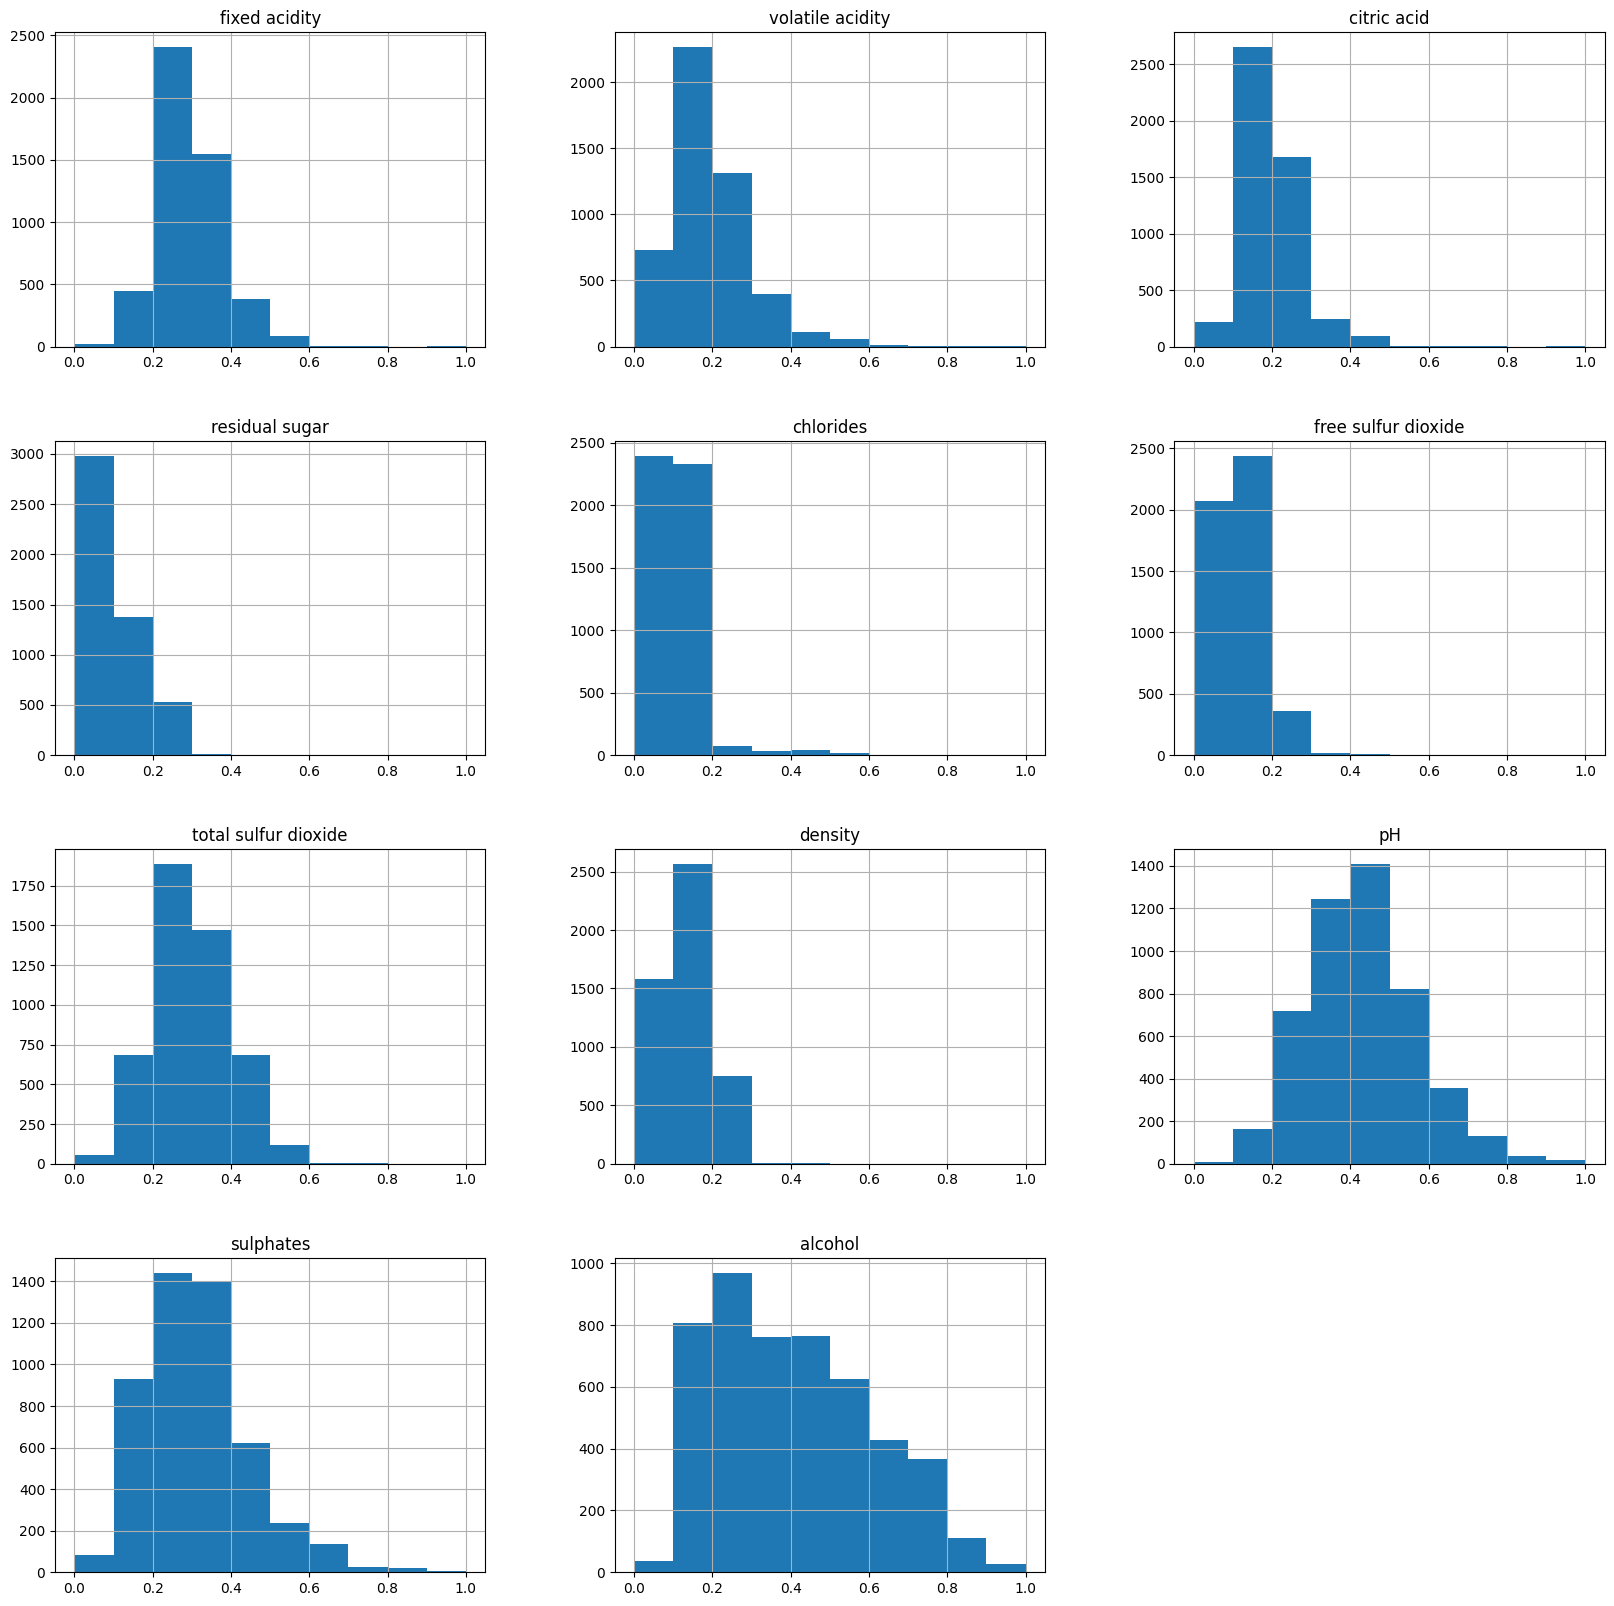

In [102]:
test_scaler = MinMaxScaler()
df_test_scaler = df.drop(columns='quality', axis=1)
test_scaler.fit(df_test_scaler)
df_test = pd.DataFrame(test_scaler.transform(df_test_scaler), columns=df_test_scaler.columns)
df_test.hist(figsize=(20,20))
plt.show()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


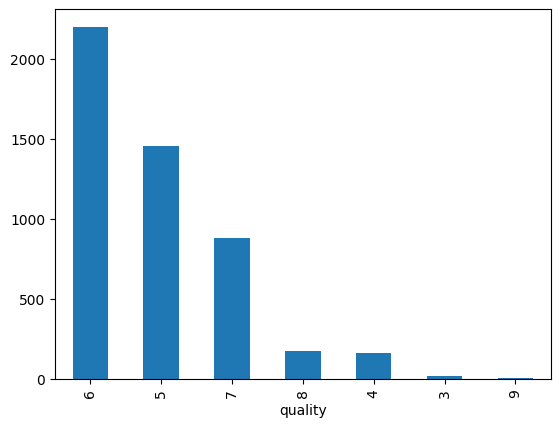

In [103]:
df['quality'].value_counts().plot.bar()
print(df['quality'].value_counts())

Basert på dataene i seksjonen over så ser vi tydelig at datasette har en betydelig skjevfordeling i target verdiene og at det er en over representasjon for verdier på 5 og 6, samt at det også er mange rader med verdi 7 i 'quality' kolonnen, mens det er veldig få verdier registrert for 9 og 3. Det er også betydelig færre verdier registrert for verdi 8 og 4 kontra 7, 5 og 6.

I dette datasettet er enda ferre verdier for den miste klassen i 'quality' kolonnen, dette gjør at det ikke er mulig å bruke upsamling med SMOTENC, så for dette datasette kommer jeg til å droppe alle radene med verdier/kategorier 3 og 9 for 'quality' for å se om dette kan gi bedre resultaer enn det som ble oppnåd for red-wine.

I forhold til oppdeling av datasettet så kommer jeg til å bruke stratified sampling med en fordeling på 60, 20 ,20% til henholdsvis train, validation, test. Jeg har valgt denne spilten da jeg mener at dette vil gi den beste balansen mellom traing, validation og test data. 

Jeg kommer til å legge inn mulighet for både down og upsamling i analysen. Videre vil det også være hensiktsmessig å gjøre eventuell upsamling etter oppdeling av datasettet i train, validation og test, slik at vil redusere risikoen for overfiting pga. de syntetiske dataene.

Det vil også være nødvendig å transformere 'quality' kolonnen til en kategorisk datatype slik av vi kan bruke SMOTENC til genereringen av de sytestiske datene.

I seksjonen nedenfor gjør jeg en enkel demonstrasjon av upsampling med SMOTENC, som vi ser av resultatet så lager SMOTENC da sytetiske verdier slik at hele datasettet blir balansert. Det er imidlertid ikke nødvendigvis lurt å lage så mange syntetsiske verdier som vi må i dette tilfellet. En annen vurdering som kunnde vært gjort er og dropp radene med 8 og 3 for 'quality' kolonnen og balansere datasettet på denne måten.

In [104]:
drop_3 = df[df.quality == 3]
drop_9 = df[df.quality == 9]

df = df.drop(drop_3.index)
df = df.drop(drop_9.index)


quality
6    2198
5    1457
7     880
8     175
4     163
Name: count, dtype: int64


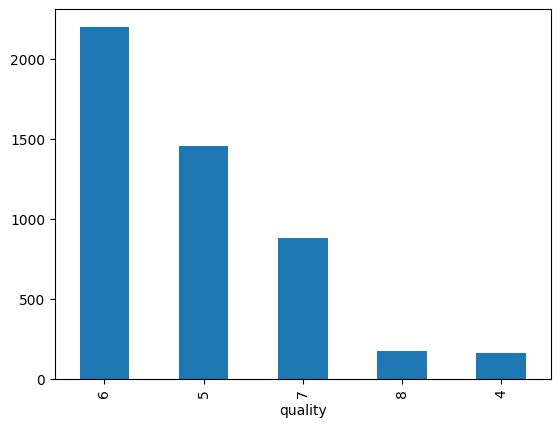

In [105]:
df['quality'] = df['quality'].astype('category')
df['quality'].value_counts().plot.bar()
print(df['quality'].value_counts())

quality
4    2198
5    2198
6    2198
7    2198
8    2198
Name: count, dtype: int64


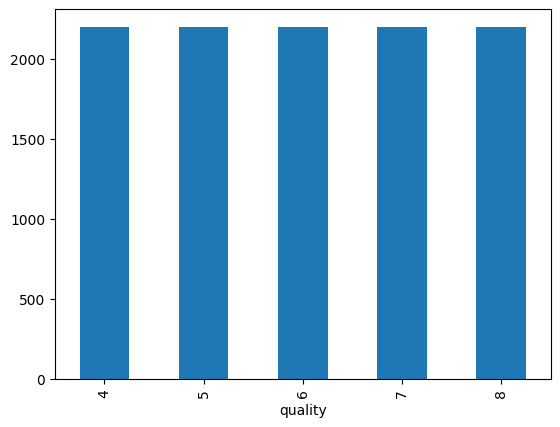

In [ ]:
df_oversampled, _ = SMOTENC('auto').fit_resample(df, df['quality'])
df_oversampled['quality'].value_counts().plot.bar()
print(df_oversampled['quality'].value_counts())

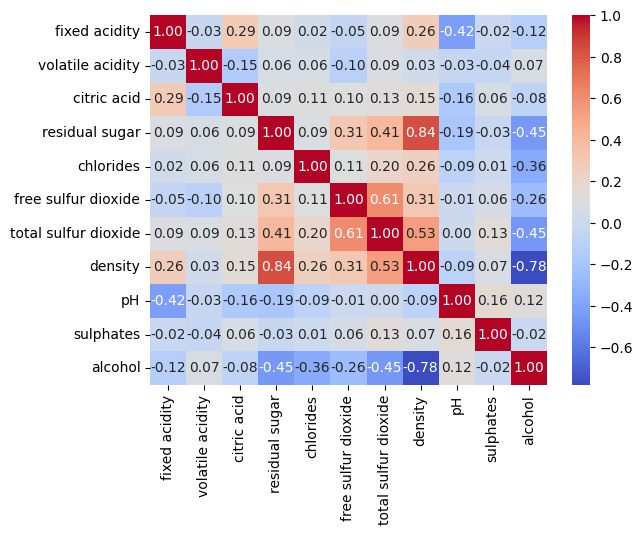

In [107]:
df_features = df.drop(columns='quality', axis=1)
matrix = df_features.corr()
sb.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Som vi ser av heatmapen over så er det ingen korrelasjoner som er sterkere en 0.70 eller -0.70 og fleste parten av feature settene har velig liten korrelasjon, så jeg velger derfor ikke å gjøre noen videre analyse og behandling av datasette med principal component analysisk (pca) i forhold til dette. 

In [108]:
# funksjon for splitting av dataset, og downsampling for balanser
def split_dataset(data, down_s=0, up_s=False):
    train_val = data.groupby("quality", observed=False, group_keys=False)[data.columns].sample(frac=0.8)
    test = data.drop(train_val.index)
    train = train_val.groupby("quality", observed=False, group_keys=False)[train_val.columns].sample(frac=0.75)
    validation = train_val.drop(train.index)

    # funksjonalitet for down og upsampling som gjennomførers kun på train delen av datasette for å unngå overfiting.
    if(down_s > 0): train = downsampling(data, down_s)
    if(up_s): train, _ = SMOTENC('auto').fit_resample(train, train['quality'])
        
    return [train, validation, test]

def check_split_dataset(data):
    print(data[0]["quality"].value_counts()/data[0].shape[0])
    print(data[1]["quality"].value_counts()/data[1].shape[0])
    print(data[2]["quality"].value_counts()/data[2].shape[0])

def downsampling(data, n):
    df_3 = df[df['quality'] == 3]
    if(df_3['quality'].count() > n): df_3 = df_3.sample(n)

    df_4 = df[df['quality'] == 4]
    if(df_4['quality'].count() > n): df_4 = df_4.sample(n)

    df_5 = df[df['quality'] == 5]
    if(df_5['quality'].count() > n): df_5 = df_5.sample(n)

    df_6 = df[df['quality'] == 6]
    if(df_6['quality'].count() > n): df_6 = df_6.sample(n)

    df_7 = df[df['quality'] == 7]
    if(df_7['quality'].count() > n): df_7 = df_7.sample(n)

    df_8 = df[df['quality'] == 8]
    if(df_8['quality'].count() > n): df_8 = df_8.sample(n)
    
    df_down = pd.concat([df_3, df_4, df_5, df_6 , df_7, df_8])

    return df_down

def split_targets_and_features(data):
    targets = data.quality
    features = data.drop("quality", axis=1)

    return [features, targets]

def create_set_of_targets_and_features(data, min_max=False, mean=False):
    train = split_targets_and_features(data[0])
    validation = split_targets_and_features(data[1])
    test = split_targets_and_features(data[2])

    #funksjon for min_max normalisering av data
    if(min_max):
        scaler_min_max =MinMaxScaler()
        scaler_min_max.fit(train[0])
        train[0] = pd.DataFrame(scaler_min_max.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_min_max.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_min_max.transform(test[0]), columns=test[0].columns)    
    
    # funksjon for mean normalisering av data
    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(train[0])
        train[0] = pd.DataFrame(scaler_mean.transform(train[0]), columns=train[0].columns)
        validation[0] = pd.DataFrame(scaler_mean.transform(validation[0]), columns=validation[0].columns)
        test[0] = pd.DataFrame(scaler_mean.transform(test[0]), columns=test[0].columns)

    return [train, validation, test]

# hovedfunksjon for splitting av dataset med valgmulighet for normalisering
def create_full_dataset(input, min_max=False, mean=False, down_s=0, up_s=False):
    data = split_dataset(input, down_s=0 ,up_s=False)
    dataset = create_set_of_targets_and_features(data, min_max, mean)

    return dataset

In [109]:
def evaluate_model_external(true_labels, pred_labels):
    adjusted_rand = adjusted_rand_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels) 
    v_measure = v_measure_score(true_labels, pred_labels)

    return [adjusted_rand, homogeneity, completeness, v_measure]

def external_results_print(adjusted_rand, homogeneity, completeness, v_measure):
    print(f'Adjusted rand score: {np.mean(adjusted_rand):.2f} +- {np.std(adjusted_rand):.2f}')
    print(f'Homogeneity score: {np.mean(homogeneity):.2f} +- {np.std(homogeneity):.2f}')
    print(f'Completness score: {np.mean(completeness):.2f} +- {np.std(completeness):.2f}')
    print(f'V-measure score: {np.mean(v_measure):.2f} +- {np.std(v_measure):.2f}')

def evaluate_model_internal(data_features, pred_labels):
    silhouette = silhouette_score(data_features, pred_labels)
    davies = davies_bouldin_score(data_features, pred_labels)
    
    return [silhouette, davies]

def internal_results_print(silhouette, davies):
    print(f'Silhouette score: {np.mean(silhouette):.2f} +- {np.std(silhouette):.2f}')
    print(f'Davies score: {np.mean(davies):.2f} +- {np.std(davies):.2f}')

def append_values(results_external, results_internal, adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies):
        adjusted_rand.append(results_external[0])
        homogeneity.append(results_external[1])
        completeness.append(results_external[2])
        v_measure.append(results_external[3])
        silhouette.append(results_internal[0])
        davies.append(results_internal[1])

def validate_kmeans(classifier, runs=1, test=False, min_max=False, mean=False, down_s=0 ,up_s=False, external=True):
    train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure, train_silhouette, train_davies = [], [], [], [], [], []
    validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure, validate_silhouette, validate_davies = [], [], [], [], [], []
    test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure, test_silhouette, test_davies = [], [], [], [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df)
        model = classifier.fit(dataset[0][0])
        pred_train = model.labels_
        pred_validate = model.predict(dataset[1][0])
        pred_test = model.predict(dataset[2][0])

        r_train_external = evaluate_model_external(dataset[0][1], pred_train)
        r_train_internal = evaluate_model_internal(dataset[0][0], pred_train)
        append_values(r_train_external, r_train_internal, train_adjusted_rand, train_homogeneity, train_completeness, 
                      train_v_measure, train_silhouette, train_davies)
        
        r_validate_external = evaluate_model_external(dataset[1][1], pred_validate)
        r_validate_internal = evaluate_model_internal(dataset[1][0], pred_validate)
        append_values(r_validate_external, r_validate_internal, validate_adjusted_rand, validate_homogeneity, validate_completeness, 
                      validate_v_measure, validate_silhouette, validate_davies)
        
        if(test):
            r_test_external = evaluate_model_external(dataset[2][1], pred_test)
            r_test_internal = evaluate_model_internal(dataset[2][0], pred_test)
            append_values(r_test_external, r_test_internal, test_adjusted_rand, test_homogeneity, test_completeness, 
                      test_v_measure, test_silhouette, test_davies)

    print('Traning ressults:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(train_adjusted_rand, train_homogeneity, train_completeness, train_v_measure)
    if not(external):    
        print('**********************************')
        print("Internal:")
        internal_results_print(train_silhouette, train_davies)
    print('')
    print('Validation results:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(validate_adjusted_rand, validate_homogeneity, validate_completeness, validate_v_measure)
    if not(external):
        print('**********************************')
        print('Internal:')
        internal_results_print(validate_silhouette, validate_davies)
    if(test):
        print('')
        print('Test results:')
        if(external):
            print('**********************************')
            print('External:')
            external_results_print(test_adjusted_rand, test_homogeneity, test_completeness, test_v_measure)
        if not(external):
            print('**********************************')
            print('Internal:')
            internal_results_print(test_silhouette, test_davies)

def validate_agglomerative(classifier, min_max=False, mean=False, external=True):
    adjusted_rand, homogeneity, completeness, v_measure, silhouette, davies = [], [], [], [], [], []
    dataset = split_targets_and_features(df)

    if(min_max):
        scaler_min_max = MinMaxScaler()
        scaler_min_max.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_min_max.transform(dataset[0]), columns=dataset[0].columns)

    if(mean):
        scaler_mean = StandardScaler()
        scaler_mean.fit(dataset[0])
        dataset[0] = pd.DataFrame(scaler_mean.transform(dataset[0]), columns=dataset[0].columns)

    model = classifier.fit(dataset[0])
    pred_labels = model.labels_    

    r_external = evaluate_model_external(dataset[1], pred_labels)
    r_internal = evaluate_model_internal(dataset[0], pred_labels)
    append_values(r_external, r_internal, adjusted_rand, homogeneity, completeness, 
                    v_measure, silhouette, davies)

    print('Ressults:')
    if(external):
        print('**********************************')
        print('External:')
        external_results_print(adjusted_rand, homogeneity, completeness, v_measure)
    if not (external):
        print('**********************************')
        print("Internal:")
        internal_results_print(silhouette, davies)

def optimise_clusters(data, max_cluster):
    silhouette = []
    inertias = []
    n_clusters = range(2, max_cluster)
    data_features = data.drop(columns='quality', axis=1)
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data_features)

        inertias.append(kmeans.inertia_)
        silhouette.append(silhouette_score(data_features, kmeans.predict(data_features)))
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(n_clusters, inertias, "o-")
    ax[1].plot(n_clusters, silhouette, "o-")

def silhouette_plot(data, max_clusters):
    fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,5))
    n_clusters = range(2, max_clusters)
    for n in n_clusters:        
        kmeans = KMeans(n_clusters=n).fit(data)       
        predictions = kmeans.predict(data)        
        silhouette_average = silhouette_score(data, predictions)        
        silhouette_sample = silhouette_samples(data, predictions)        
        x_start = 0
        for i in range(n):           
            ith_cluster_samples = silhouette_sample[kmeans.labels_ == i]
            ith_cluster_samples.sort()            
            x_end = x_start + ith_cluster_samples.shape[0]            
            ax[(n-2)//4][(n-2)%4].fill_between(np.arange(x_start, x_end), 0, ith_cluster_samples)
            ax[(n-2)//4][(n-2)%4].plot([0,silhouette_sample.shape[0]],[silhouette_average, silhouette_average], '--', color='black')
            x_start = x_end 


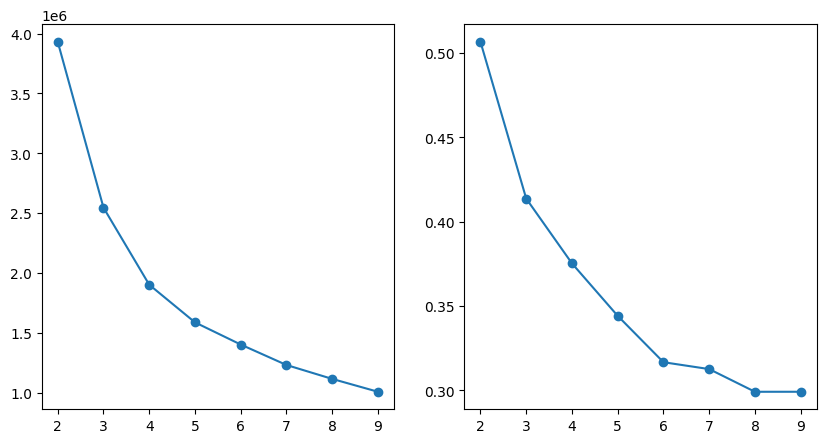

In [110]:
optimise_clusters(df, 10)

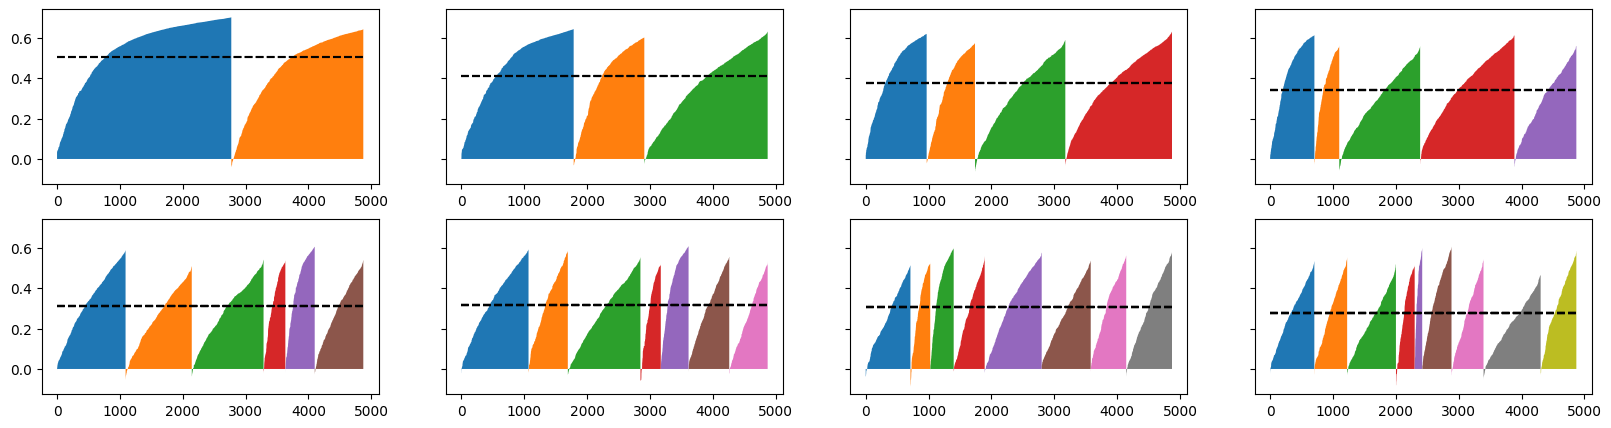

In [111]:
silhouette_plot(df, 10)

Før vi starter med selve testingen av clustering modelene for datasette så kjører vi analyse for å se om det er noen tydelige naturlig clustere uten om de target verdiene vi allerde har i datasettet. Ut i fra plotene over for inertia fra en kmeans modell, silhouette_score og silhouette coefficient plot, så kan vi se at det for inertia oppstår en utflatting av kurven ved ca. 6-7 clustere litt ut i fra variasjon noe modellen kjøres flere ganger. Dette kan tyde på at denne modellen sier at det er en naturlig fordeling i dette område, men selve inertia verdien er relativt høy så dette kan indikere at dette alikvel ikke en god oppdeling.

Når vi ser på plottet for silhouette score så ser vi at denne får lavere verdier jo flere clustere som legges til som tyder på at det optimale ut i fra denne vurderingen er at det er færre clustere. Når vi også ser på silhouette coefficient plottet så ser vi den samme trenden av snitt verdien for silhouette synker jo flere clustere som legges til, samt at det er relativt stor forskjell mellom størelsene på de forskjellige cluster fordelingene. Det er også hvert å merke seg at det ser ut til å bli noe flere negativ verdier for silhouette score ved flere clustere som indikerer at modellen da tildeler verdier til feil clustere. 

Totaltsett så tydere dette på at det ikke noen veldig gode naturlige clustere i datasette uten noen videre behandling av datasettet.

For testing av Kmeans modellen så kommer jeg til å splitte opp vurderingen i to hoveddeler med fokus på external vurdring for den ene del og internal for den andre delen. I utgangspunktet kommer jeg i hovedsak til å bruke antall clustere som tuning parameterm, selv om dette blir mest relevant for intervall vurderingen. Videre kommer jeg til å bruke valg muligher jeg har bygd inn i fuksjonene mine for å vurdere om bruk av forskjellige scalerings metoder og down og upsamling for å se om dette kan forbedre resultatet til kmeans modellen.

In [112]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.01
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.01


In [113]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.04 +- 0.00


In [114]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [115]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=50)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [116]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, up_s=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.01
V-measure score: 0.03 +- 0.01


In [117]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=50 ,up_s=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.02 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [118]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=50 ,up_s=True, min_max=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [119]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=50 ,up_s=True, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.01
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.01


In [120]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=200 ,up_s=True, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.01
V-measure score: 0.03 +- 0.01


In [121]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, down_s=250 ,up_s=True, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.01
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.01


In [122]:
kmans = KMeans(n_clusters=5)
validate_kmeans(kmans, runs=5, down_s=250 ,up_s=True, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [123]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5, down_s=250 ,up_s=True, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [124]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, test=True, runs=20, mean=True)

Traning ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.02 +- 0.00
V-measure score: 0.03 +- 0.00

Validation results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00

Test results:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.04 +- 0.01
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


Som vi ser av resultatene over for testing av K-means modellen over så er det vansklig å få denne modellen til prestere bra med dette datasette i forhold til external vurdering, det eneste som kan se til å gi en veldig lite forbedring er scalering av feature verdiene.

In [125]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.01


In [126]:
kmans = KMeans(n_clusters=3)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.41 +- 0.00
Davies score: 0.79 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.41 +- 0.01
Davies score: 0.79 +- 0.01


In [127]:
kmans = KMeans(n_clusters=4)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.38 +- 0.00
Davies score: 0.83 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.37 +- 0.00
Davies score: 0.84 +- 0.01


In [128]:
kmans = KMeans(n_clusters=5)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.35 +- 0.00
Davies score: 0.90 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.34 +- 0.00
Davies score: 0.91 +- 0.01


In [129]:
kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.32 +- 0.01
Davies score: 0.96 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.32 +- 0.01
Davies score: 0.97 +- 0.02


In [130]:
kmans = KMeans(n_clusters=7)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.32 +- 0.00
Davies score: 0.96 +- 0.02

Validation results:
**********************************
Internal:
Silhouette score: 0.31 +- 0.01
Davies score: 0.97 +- 0.01


In [131]:
kmans = KMeans(n_clusters=8)
validate_kmeans(kmans, runs=5, external=False)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.30 +- 0.00
Davies score: 0.99 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.30 +- 0.01
Davies score: 0.99 +- 0.03


In [132]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, min_max=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.50 +- 0.00
Davies score: 0.70 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.70 +- 0.01


In [133]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.69 +- 0.01


In [134]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True, up_s=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.69 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.00
Davies score: 0.70 +- 0.01


In [135]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True, down_s=50)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.71 +- 0.01


In [136]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True, up_s=True, down_s=50)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.70 +- 0.01


In [137]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True, up_s=True, down_s=100)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.70 +- 0.01


In [138]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=5, external=False, mean=True, up_s=True, down_s=200)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.70 +- 0.01


In [139]:
kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=20, external=False, test=True, mean=True)

Traning ressults:
**********************************
Internal:
Silhouette score: 0.51 +- 0.00
Davies score: 0.70 +- 0.00

Validation results:
**********************************
Internal:
Silhouette score: 0.51 +- 0.01
Davies score: 0.69 +- 0.01

Test results:
**********************************
Internal:
Silhouette score: 0.50 +- 0.01
Davies score: 0.70 +- 0.01


For internal vurdering for denne k-means modellen så ser vi at det er 2 clustere som gir best resultat, men det er mye som tyder på at denne delingen heller ikke er optimal og de featurene vi har ikke gir noe gode muligheter til å dele opp forskjellige clustere. Det gir heller ikke noe forbedring for internal vurdering og up eller downsample datasettet, eller legge inn scalering av feature verdiene.

For testing og vurdering av Agglomerativ Clustering kommer jeg ikke til å bruke fuksjonalitet for up og downsamlping siden den addlomerative modellen ikke kan brukes til å predikere verdier og det derfor ikke er noen hensikt å dele opp datasette i forskjellige deler for test, validation og train. Dermed vil bruke av denne type fuksjnalitet lett før til overfitting. I tillegg har jeg ikke lagt til noen fuksjonalitet for loops denne modelen da dette ikke har noen hensikt siden vi ikke deler opp datasettet i forskjellige deler.

Videre kommer jeg til å legge tuning for linkage type som en del av tuning for denne modellen.

Jeg kommer også Agglomertiv clustering å dele opp vurderingen for external og internal.

In [140]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg)

Ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.03 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.03 +- 0.00


In [141]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, mean=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.05 +- 0.00
Homogeneity score: 0.07 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.06 +- 0.00


In [142]:
agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.05 +- 0.00
Homogeneity score: 0.08 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.07 +- 0.00


In [143]:
agg = AgglomerativeClustering(n_clusters=6, linkage="complete")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.01 +- 0.00
Homogeneity score: 0.01 +- 0.00
Completness score: 0.03 +- 0.00
V-measure score: 0.02 +- 0.00


In [144]:
agg = AgglomerativeClustering(n_clusters=6, linkage="single")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: -0.00 +- 0.00
Homogeneity score: 0.00 +- 0.00
Completness score: 0.14 +- 0.00
V-measure score: 0.00 +- 0.00


In [145]:
agg = AgglomerativeClustering(n_clusters=6, linkage="average")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.00 +- 0.00
Homogeneity score: 0.00 +- 0.00
Completness score: 0.16 +- 0.00
V-measure score: 0.00 +- 0.00


In [146]:
agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.05 +- 0.00
Homogeneity score: 0.08 +- 0.00
Completness score: 0.07 +- 0.00
V-measure score: 0.07 +- 0.00


In [147]:
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.07 +- 0.00
Homogeneity score: 0.08 +- 0.00
Completness score: 0.08 +- 0.00
V-measure score: 0.08 +- 0.00


In [148]:
agg = AgglomerativeClustering(n_clusters=7, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.09 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.07 +- 0.00


In [149]:
agg = AgglomerativeClustering(n_clusters=8, linkage="ward")
validate_agglomerative(agg, min_max=True)

Ressults:
**********************************
External:
Adjusted rand score: 0.04 +- 0.00
Homogeneity score: 0.09 +- 0.00
Completness score: 0.06 +- 0.00
V-measure score: 0.07 +- 0.00


Som vi ser av resultatene for external vurdering for Agglomerativ clustering så prestere denne noe bedre enn k-means
(se kopi av verdiene). I forhold til forbedring av modellen så var det kun scaling av feature verdiene som ga postiv uttelling og min_mix scaling ga best resultater.

For dette datasette så var det Agglomerativ clustering som presterte best når vi vurderte prestasjonen ut i fra en external vurdering opp mot 'quality' kolonnen i datasettet. Som vi ser av verdiene under, så får Agglomerativ bedre resultat for alle verdiene selv om prestasjonen til modellen for dette datasettet fortsatt ikke er veldig god.

Totalsett ser vi at den beste modellen for agglomerativ clustering har noe bedre adjusted rand score som forteller at denne har bedre presisjon for klasifiseringen som gjøres, videre viser homogenity score at modellen er noe bedre til å få clusterene til å innehold ferre forskjellige klasser for target verdiene. Mens completeness score vider viser at modellen er litt bedre til å hold alle medlemmene av en gitt klasse satt til samme cluster.
V-measure er en samling av homogeneity og completness, dvs. hvis en av disse verdiene får veldig bra resultat, mens den andre for veldig dårlig så balansere v-measure ut dette.

kmans = KMeans(n_clusters=6)
validate_kmeans(kmans, test=True, runs=20, mean=True)
Traning ressults:
**********************************
External:
Adjusted rand score: -0.00 +- 0.00
Homogeneity score: 0.05 +- 0.01
Completness score: 0.04 +- 0.01
V-measure score: 0.04 +- 0.01

Validation results:
**********************************
External:
Adjusted rand score: -0.00 +- 0.01
Homogeneity score: 0.06 +- 0.01
Completness score: 0.05 +- 0.01
V-measure score: 0.06 +- 0.01

Test results:
**********************************
External:
Adjusted rand score: -0.00 +- 0.01
Homogeneity score: 0.07 +- 0.01
Completness score: 0.06 +- 0.01
V-measure score: 0.06 +- 0.01


agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
validate_agglomerative(agg, min_max=True)
Ressults:
**********************************
External:
Adjusted rand score: 0.08 +- 0.00
Homogeneity score: 0.14 +- 0.00
Completness score: 0.10 +- 0.00
V-measure score: 0.12 +- 0.00

In [150]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.46 +- 0.00
Davies score: 0.66 +- 0.00


In [151]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.38 +- 0.00
Davies score: 0.77 +- 0.00


In [152]:
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.30 +- 0.00
Davies score: 0.98 +- 0.00


In [153]:
agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.29 +- 0.00
Davies score: 0.97 +- 0.00


In [154]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False, mean=True)

Ressults:
**********************************
Internal:
Silhouette score: 0.20 +- 0.00
Davies score: 1.86 +- 0.00


In [155]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False, min_max=True)

Ressults:
**********************************
Internal:
Silhouette score: 0.20 +- 0.00
Davies score: 1.73 +- 0.00


In [156]:
agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.46 +- 0.00
Davies score: 0.66 +- 0.00


In [157]:
agg = AgglomerativeClustering(n_clusters=2, linkage="single")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.72 +- 0.00
Davies score: 0.19 +- 0.00


In [158]:
agg = AgglomerativeClustering(n_clusters=2, linkage="complete")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.37 +- 0.00
Davies score: 0.72 +- 0.00


In [159]:
agg = AgglomerativeClustering(n_clusters=2, linkage="average")
validate_agglomerative(agg, external=False)

Ressults:
**********************************
Internal:
Silhouette score: 0.60 +- 0.00
Davies score: 0.52 +- 0.00


Som vi ser av resultatene for denne modellen så gir det best resultater med 2 clustere og linkage = average, singel, complete (likt resultat for disse) for agglomerativ clustering modellen ved internal vurdering. Denne modellen prestere også bedre enn k-means modellen (se verdiene under). For k-means så var det også 2 clustere som ga best resultat ved internal vurdering. 

Når vi sammenligner resultatene så ser vi at agglomerativ fikk en silhouette score på 0.83 kontra 0.60 for k-means, dette betyr i praksis at median avstanden fra verdiene i clusterene til senturm av clusteret er mindre enn median avstanden til sentrum i andre clustere.

For Davies score fikk agglomerativ en verdi på 0.14 kontra en verdi på 0.62, dette betyr agglomerativ har oppnår bedre sepparasjon mellom clusterene enn k-means oppnår.

kmans = KMeans(n_clusters=2)
validate_kmeans(kmans, runs=20, external=False, test=True, mean=True)
Traning ressults:
**********************************
Internal:
Silhouette score: 0.61 +- 0.01
Davies score: 0.61 +- 0.01

Validation results:
**********************************
Internal:
Silhouette score: 0.60 +- 0.01
Davies score: 0.62 +- 0.02

Test results:
**********************************
Internal:
Silhouette score: 0.60 +- 0.02
Davies score: 0.62 +- 0.03


agg = AgglomerativeClustering(n_clusters=2, linkage="average"), single og complete ga også samme resultat.
validate_agglomerative(agg, external=False)
Ressults:
**********************************
Internal:
Silhouette score: 0.83 +- 0.00
Davies score: 0.14 +- 0.00

Totaltsett ga agglomerativ clustering best resultat for både external og internal vurdering, men det er viktig å påpeke at denne modellen i utgangspunktet ikke kan brukes til å direkte predikering av verdier for andre datasette eller nye verdier. Siden du ikke direkte kan bruke denne modellen til å predikere verdier for andre datasett så har du heller ingen mulighet til å gardere deg mot overfitting siden du ikke får testet eller validert modellen med andre datasett enn det du trener modellen på.

Hvis vi ser på helheten av vurderingwn for clustering av dette datasettet så ser vi at det ikke er noen god prestasjon ved external vurdering, men vi ser at det er noe bedre resultat ved interval vurdering, samt at vi bruker naturlig clustere i datasette kontra target verdiene som er oppgitt. Dette er godt mulig at skyldes at du har veldig ujevn fordeling av target verdiene og at det veldig høy representasjon for 2 av kategoriene for disse verdiene.